In [1]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-talk')
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

import copy

import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd

np.random.seed(1596)

from hmm import HMM
from vi import GammaNormal, GaussianVI

# Sampling from Sum-HMM

In [36]:
def plot_sampling_distributions(num_samples, prob_list):
    fig, ax = plt.subplots()
    ind = np.arange(1,num_samples+1)
    width = 0.20
    prob_list = list(map(lambda x: x*100, prob_list)) # Convert to %
    state_0_probs = [x[0] for x in prob_list]
    state_1_probs = [x[1] for x in prob_list]

    ax.bar(ind+width, state_0_probs, label='$Z_0$', color='r', width=0.4, alpha=0.9)
    ax.bar(ind-width, state_1_probs, label='$Z_1$'.format(1), color='b', width=0.4, alpha=0.9)
    ax.set_ylim([0, 100])
    ax.set_xticks(ind)
    ax.set_ylabel('Probability %')
    ax.set_xlabel('Conditional State Distribution')
    ax.set_title('Cond. prob. dist. for various stages in sampling procedure')
    ax.legend()

In [39]:
def draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe):
    # Sample some values from HMM
    hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
    state_sequence = []
    for _ in range(num_samples):
        state_sequence.append(hmm.state)
        hmm.run()

    actual_outcomes = hmm.actual_outcomes
    observed_outcomes = hmm.observed_outcomes
    state_seq = state_sequence
    observed_sum = np.sum(actual_outcomes)
    print("State Seq: {}".format(state_seq))
    print("Observed Outcomes: {}".format(observed_outcomes))
    print("Actual outcomes: {}".format(actual_outcomes))
    print(observed_sum)
    
    return observed_outcomes, observed_sum

## Test Case 1

State Seq: [0, 1, 0, 1, 0]
Observed Outcomes: [6, 3, 1, 6, 6]
Actual outcomes: [6, 3, 1, 6, 6]
22


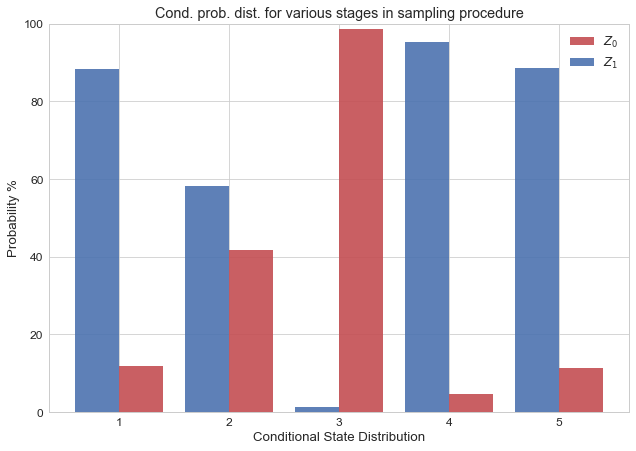

In [40]:
# Define parameters
starting_prior = [1/2, 1/2]
dice_dist1 = [1/6]*6
dice_dist2 = [1/6]*6
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1
num_samples = 5

# Sample and run inference and re-sample
observed_outcomes, observed_sum = draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe)
states_list, prob_list = hmm.sample_states(observed_outcomes, observed_sum)
plot_sampling_distributions(num_samples, prob_list)

## Test Case 2

State Seq: [1, 1, 1, 0, 1]
Observed Outcomes: [2, 6, 5, 6, 1]
Actual outcomes: [2, 6, 5, 6, 1]
20


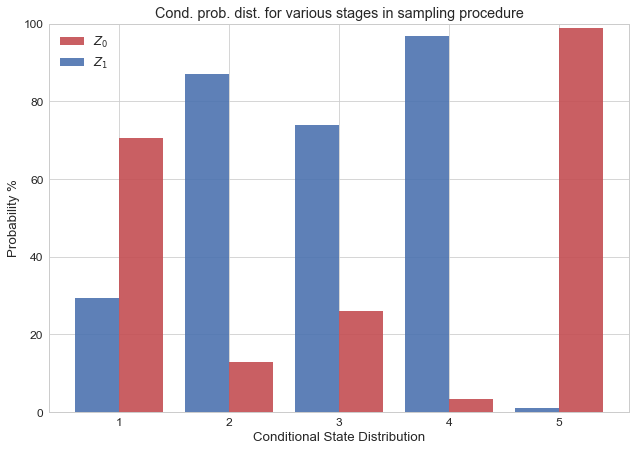

In [41]:
# Define parameters
starting_prior = [1/2, 1/2]
dice_dist1 = [90/100] + [2/100]*5
dice_dist2 = [2.5/100]*4 + [45/100]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1
num_samples = 5


# Sample and run inference and re-sample
observed_outcomes, observed_sum = draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe)
states_list, prob_list = hmm.sample_states(observed_outcomes, observed_sum)
plot_sampling_distributions(num_samples, prob_list)

## Test Case 3

State Seq: [1, 0, 0, 1, 1]
Observed Outcomes: [-1, 1, 1, -1, -1]
Actual outcomes: [6, 1, 1, 5, 6]
19


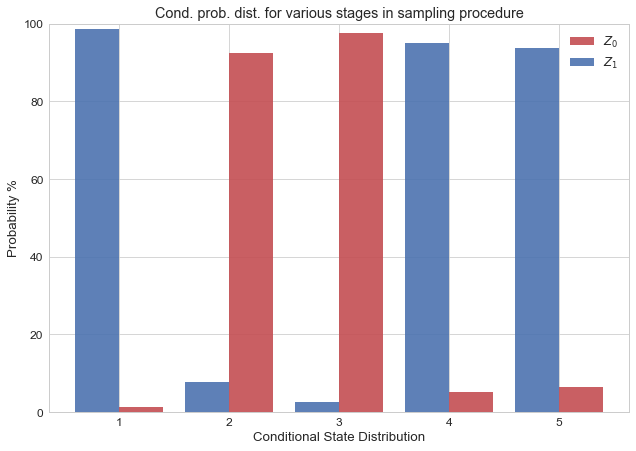

In [42]:
# Define parameters
starting_prior = [1/2, 1/2]
dice_dist1 = [90/100] + [2/100]*5
dice_dist2 = [2.5/100]*4 + [45/100]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 0.5
num_samples = 5

# Sample and run inference and re-sample
observed_outcomes, observed_sum = draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe)
states_list, prob_list = hmm.sample_states(observed_outcomes, observed_sum)
plot_sampling_distributions(num_samples, prob_list)

# Simple Variational Inference
Illustrates convergence of a simple VI algorithm for the posteriors of mean and precision for a 1-d gaussian

In [5]:
def visualize_density(rv, resolution=300, color='green', ax=None):
    tau = np.linspace(0.01,1,resolution)
    mu = np.linspace(0,2,resolution)
    X, Y = np.meshgrid(mu, tau)
    Z = rv.pdf(Y, X)
    if ax == None:
        plt.contour(X, Y, Z, colors=color);
    else:
        ax.contour(X, Y, Z, colors=color);
    
#     print(np.max(z))
#     levels = np.arange(0, np.max(z), 1e-200)
#     print(levels)
#     contour_plot = plt.contourf(mu, tau, z, levels, cmap=plt.cm.viridis)

In [6]:
dataX = np.random.normal(0,2,12) # Freeze the data

In [7]:
alpha_0 = 1
beta_0 = 2
mu_0 = 0
lambda_0 = 2
gammaNormal = GammaNormal(dataX, alpha_0, beta_0, mu_0, lambda_0)
gaussianVI = GaussianVI(dataX, alpha_0, beta_0, mu_0, lambda_0)

Gamma settings: 
 a:6.5, b:25.74697399528519
Norm settings: 
 mu:0.42367122547104297, prec:14


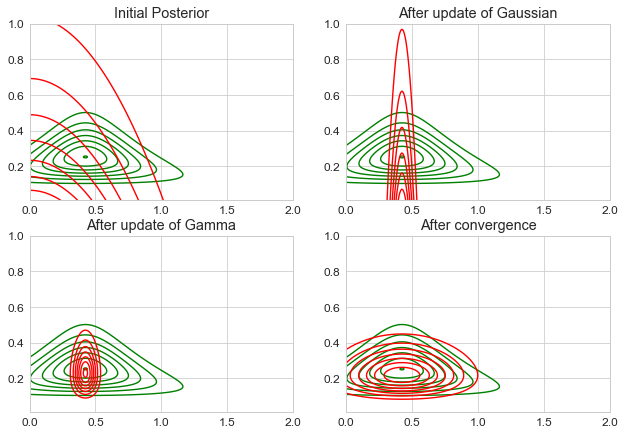

In [8]:
f, axarr = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        axarr[i, j].set_title('Initial Posterior')
        if ((i,j) == (0,1)):
            gaussianVI.update_gaussian()
            axarr[i, j].set_title('After update of Gaussian')
        elif((i,j) == (1,0)):
            axarr[i, j].set_title('After update of Gamma')
            gaussianVI.update_gamma()
        elif((i,j) == (1,1)):
            axarr[i, j].set_title('After convergence')
            for k in range(5):
                gaussianVI.update_params()

        visualize_density(gammaNormal, ax=axarr[i, j])
        visualize_density(gaussianVI,color='red', ax=axarr[i, j])

# Conditional Sum-HMM

In [11]:
def test_plot_conditional(prob_table, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
        
    ind = np.arange(1,7)
    width = 0.20
    prob_table = prob_table * 100 # Convert to %
    print(prob_table[1,:])
    print(prob_table[0,:])
    ax.bar(ind+width, prob_table[0,:], label='$Z_{} = 0$'.format(k), color='r', width=0.4, alpha=0.9)
    ax.bar(ind-width, prob_table[1,:], label='$Z_{} = 1$'.format(k), color='b', width=0.4, alpha=0.9)
    ax.set_ylim([0, 100])
    ax.set_xticks(ind)
    ax.set_ylabel('Probability %')
    ax.set_xlabel('Dice Outcome: $X_{0}$'.format(k))
    ax.set_title('Probability: $p(Z_{}, X_{} | S, O_{})$'.format(k,k,'{1:t}'))
    ax.legend()
    print('Sum of probabilities: {}'.format(np.sum(prob_table)))

## Test Case 1

In [12]:
# Define parameters
starting_prior = [1/2, 1/2]
dice_dist1 = [90/100] + [2/100]*5
dice_dist2 = [2.5/100]*4 + [45/100]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1
num_samples = 4

observed_outcomes, observed_sum = draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe)

State Seq: [1, 0, 0, 1]
Observed Outcomes: [5, 1, 1, 6]
Actual outcomes: [5, 1, 1, 6]
13


[  0.           0.           0.           0.          98.23813805   0.        ]
[ 0.          0.          0.          0.          1.76186195  0.        ]
Sum of probabilities: 100.0
[ 2.93073533  0.          0.          0.          0.          0.        ]
[ 97.06926467   0.           0.           0.           0.           0.        ]
Sum of probabilities: 100.0
[ 2.93073533  0.          0.          0.          0.          0.        ]
[ 97.06926467   0.           0.           0.           0.           0.        ]
Sum of probabilities: 100.0
[  0.           0.           0.           0.           0.          98.23813805]
[ 0.          0.          0.          0.          0.          1.76186195]
Sum of probabilities: 100.0


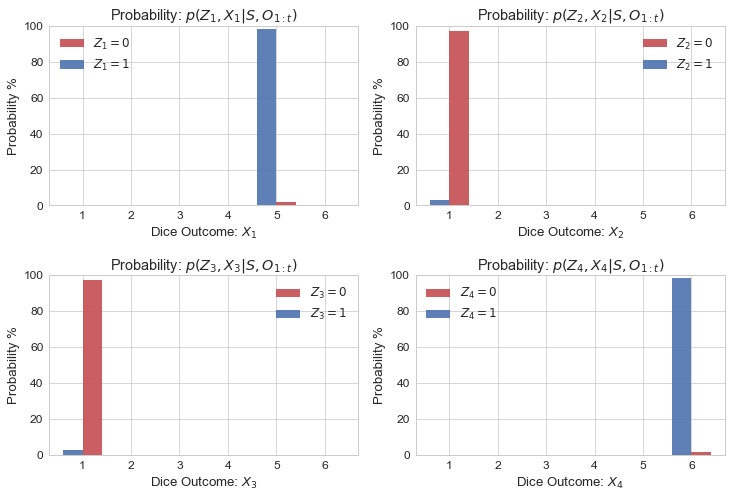

In [13]:
k_vals = [1,2,3,4]
fig, ax = plt.subplots(2,2)
indices = [(0,0),(0,1),(1,0),(1,1)]
for i,k in enumerate(k_vals):
    index = indices[i]
    prob_table = hmm.calculate_conditional(k, observed_sum, observed_outcomes)
    test_plot_conditional(prob_table, ax[index[0]][index[1]])
plt.tight_layout()

# prob_table = hmm.calculate_conditional(k, observed_sum, observed_outcomes)
# test_plot_conditional(prob_table)

## Test Case 2

In [14]:
# Define parameters
starting_prior = [1/2, 1/2]
dice_dist1 = [90/100] + [2/100]*5
dice_dist2 = [2.5/100]*4 + [45/100]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 0.4
num_samples = 4

observed_outcomes, observed_sum = draw_samples_hmm(num_samples,starting_prior,dice_dist1,dice_dist2,transition_matrix,prob_observe)

# # Sample some values from HMM
# hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
# state_sequence = []
# for _ in range(num_samples):
#     state_sequence.append(hmm.state)
#     hmm.run()

# actual_outcomes = hmm.actual_outcomes
# observed_outcomes = hmm.observed_outcomes
# state_seq = state_sequence
# observed_sum = np.sum(actual_outcomes)
# print("State Seq: {}".format(state_seq))
# print("Observed Outcomes: {}".format(observed_outcomes))
# print("Actual outcomes: {}".format(actual_outcomes))
# print(observed_sum)

State Seq: [0, 0, 1, 0]
Observed Outcomes: [-1, 1, 5, -1]
Actual outcomes: [1, 1, 5, 1]
8


[ 78.73626421   0.           0.           0.           0.           0.        ]
[ 21.26373579   0.           0.           0.           0.           0.        ]
Sum of probabilities: 100.0
[ 0.63446873  0.          0.          0.          0.          0.        ]
[ 99.36553127   0.           0.           0.           0.           0.        ]
Sum of probabilities: 100.0
[  0.           0.           0.           0.          99.43424334   0.        ]
[ 0.          0.          0.          0.          0.56575666  0.        ]
Sum of probabilities: 100.0
[ 25.78266105   0.           0.           0.           0.           0.        ]
[ 74.21733895   0.           0.           0.           0.           0.        ]
Sum of probabilities: 99.99999999999999


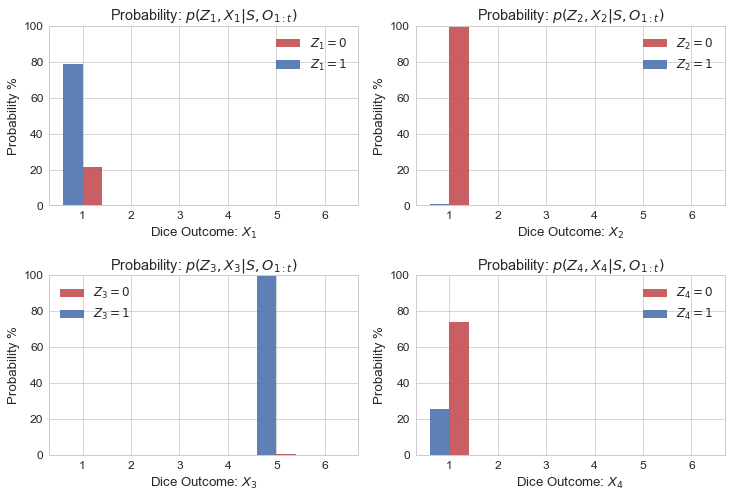

In [15]:
k_vals = [1,2,3,4]
fig, ax = plt.subplots(2,2)
indices = [(0,0),(0,1),(1,0),(1,1)]
for i,k in enumerate(k_vals):
    index = indices[i]
    prob_table = hmm.calculate_conditional(k, observed_sum, observed_outcomes)
    test_plot_conditional(prob_table, ax[index[0]][index[1]])
plt.tight_layout()

# Validation of implementation

## All Dice Fair

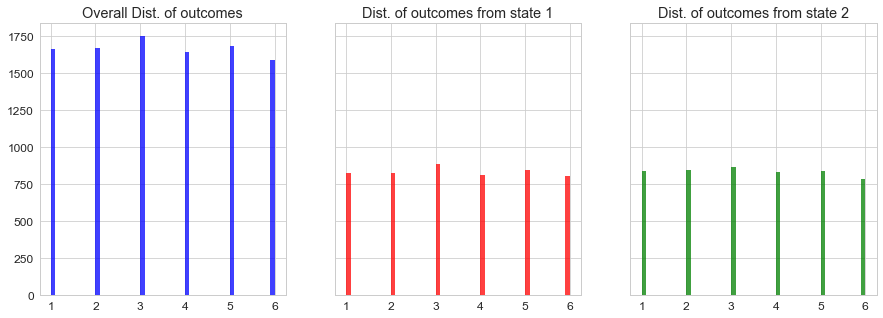

In [31]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/6]*6
dice_dist2 = [1/6]*6
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.bar([0,1], [state_sequence.count(1), state_sequence.count(2)])

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')

## Table1 Dice fair, Table2 Dice biased

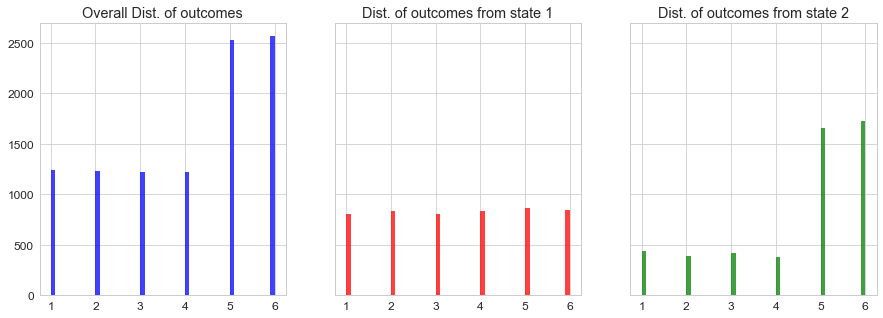

In [32]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/6]*6
dice_dist2 = [1/12]*4 + [2/6]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')

## Dice 1 biased, Dice 2 biased

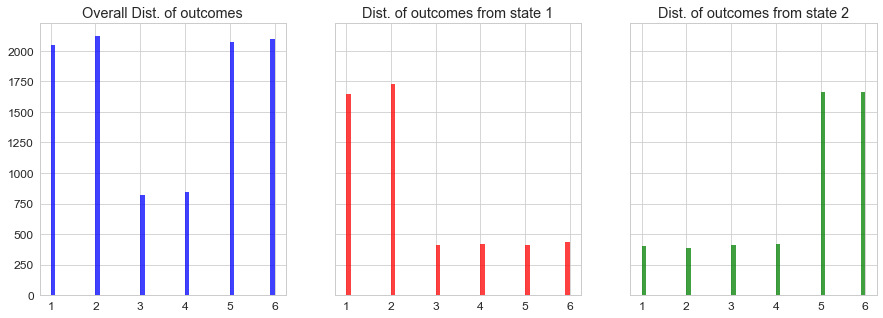

In [33]:
starting_prior = [1/2, 1/2]
dice_dist1 = [2/6]*2 + [1/12]*4
dice_dist2 = [1/12]*4 + [2/6]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')